In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, fft, interpolate
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis

In [2]:
# iterative cooley tukey fft
def cooley_tukey_fft(x):
    x = np.asarray(x, dtype=float)
    N = x.shape[0]
    if np.log2(N) % 1 > 0:
        raise ValueError("must be a power of 2")
        
    N_min = min(N, 2)
    
    n = np.arange(N_min)
    k = n[:, None]
    M = np.exp(-2j * np.pi * n * k / N_min)
    X = np.dot(M, x.reshape((N_min, -1)))
    
    while X.shape[0] < N:
        X_even = X[:, :int(X.shape[1] / 2)]
        X_odd = X[:, int(X.shape[1] / 2):]
        terms = np.exp(-1j * np.pi * np.arange(X.shape[0]) / X.shape[0])[:, None]
        X = np.vstack([X_even + terms * X_odd, X_even - terms * X_odd])
    
    return X.ravel()

# recursive iteration fft
def recursive_fft(x):
    N = len(x)
    if N <= 1: return x
    even = recursive_fft(x[0::2])
    odd =  recursive_fft(x[1::2])
    T= [exp(-2j*pi*k/N)*odd[k] for k in range(N//2)]
    return [even[k] + T[k] for k in range(N//2)] + \
           [even[k] - T[k] for k in range(N//2)]

# read raw data
def read_data(filename):
    result = []  
    with open(filename,'r') as file:  
        csvReader=csv.reader(file)  
        for line in csvReader:
            result.append(float(line[0]))
    return result

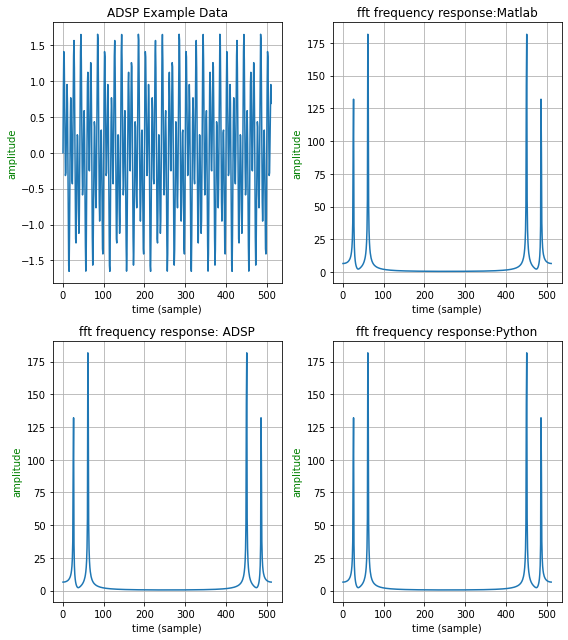

In [3]:
# we need imaginary part in time domain while ADSP is processing
# but remobe imaginary part of data now
# so we can analysis 
dataSet0 = read_data("fft_data/inputcomplx512.dat")
dataSet0 = dataSet0[0::2]
x_axis0 = np.arange(len(dataSet0))

dataSet1 = read_data("fft_data/FFT512complx_ADSP0407.dat")
x_axis1 = np.arange(len(dataSet1)//2)
complx1 = np.zeros(len(dataSet1)//2, complex)
complx1.real = dataSet1[1::2]
complx1.imag = dataSet1[0::2]

dataSet2 = read_data("fft_data/FFT512complx_Matlab.dat")
x_axis2 = np.arange(len(dataSet2)//2)
complx2 = np.zeros(len(dataSet2)//2, complex)
complx2.real = dataSet2[1::2]
complx2.imag = dataSet2[0::2]

dataSet3 = cooley_tukey_fft(dataSet0)
x_axis3 = np.arange(len(dataSet3))

fig, axes = plt.subplots(2, 2, figsize=(8, 9))

axes[0][0].plot(x_axis0, dataSet0)
axes[0][0].set_title('ADSP Example Data')
axes[0][0].set_xlabel('time (sample)')
axes[0][0].set_ylabel('amplitude', color='g')
axes[0][0].grid()

axes[1][0].plot(x_axis1, abs(complx1))
axes[1][0].set_title('fft frequency response: ADSP')
axes[1][0].set_xlabel('time (sample)')
axes[1][0].set_ylabel('amplitude', color='g')
axes[1][0].grid()

axes[0][1].plot(x_axis2, abs(complx2))
axes[0][1].set_title('fft frequency response:Matlab')
axes[0][1].set_xlabel('time (sample)')
axes[0][1].set_ylabel('amplitude', color='g')
axes[0][1].grid()

axes[1][1].plot(x_axis3, abs(dataSet3))
axes[1][1].set_title('fft frequency response:Python')
axes[1][1].set_xlabel('time (sample)')
axes[1][1].set_ylabel('amplitude', color='g')
axes[1][1].grid()

plt.tight_layout()
plt.show()

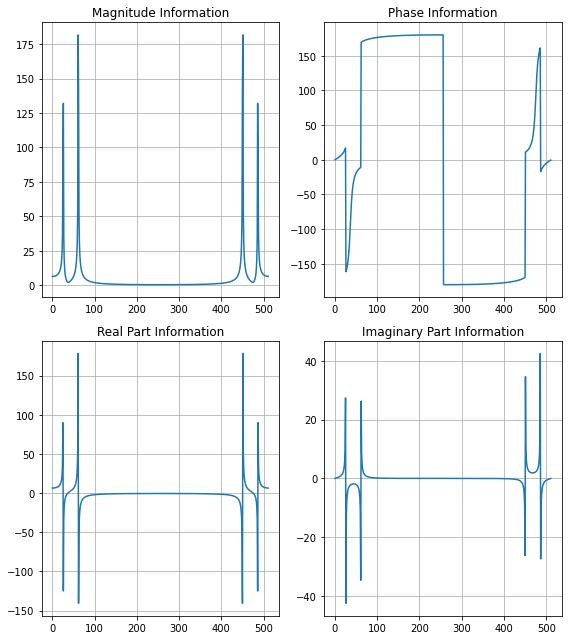

In [4]:
x_axis = np.arange(len(dataSet1)//2)

y_axis_phase = np.zeros(len(dataSet1)//2)
y_axis_magnitude = np.zeros(len(dataSet1)//2)

Im = np.zeros(len(dataSet1)//2)
Re = np.zeros(len(dataSet1)//2)

for index, element in enumerate(dataSet1):
    if index % 2 == 1:
        Im[(index-1)//2] = element
    else:
        Re[(index)//2] = element

for i in range(len(dataSet1)//2):
    y_axis_phase[i] = np.arctan2(Im[i], Re[i])*180/np.pi
    y_axis_magnitude[i] = np.sqrt(np.power(Im[i],2)+np.power(Re[i],2))
    
    
fig, axes = plt.subplots(2, 2, figsize=(8, 9))

axes[0][0].plot(x_axis, y_axis_magnitude)
axes[0][0].set_title('Magnitude Information')
axes[0][0].grid()

axes[0][1].plot(x_axis, y_axis_phase)
axes[0][1].set_title('Phase Information')
axes[0][1].grid()

axes[1][0].plot(x_axis, Re)
axes[1][0].set_title('Real Part Information')
axes[1][0].grid()

axes[1][1].plot(x_axis, Im)
axes[1][1].set_title('Imaginary Part Information')
axes[1][1].grid()


plt.tight_layout()

plt.show()

(<Figure size 720x720 with 4 Axes>,
 [<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>])

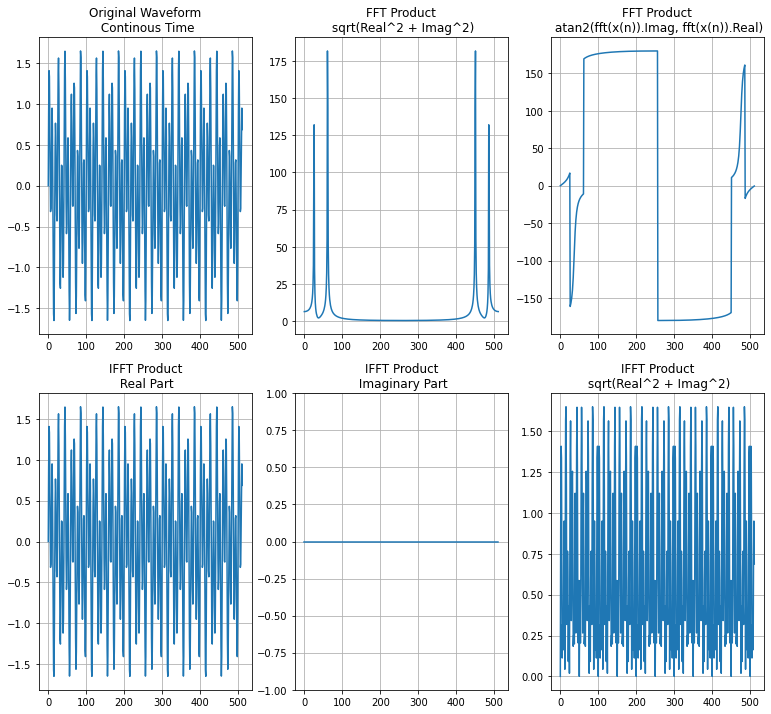

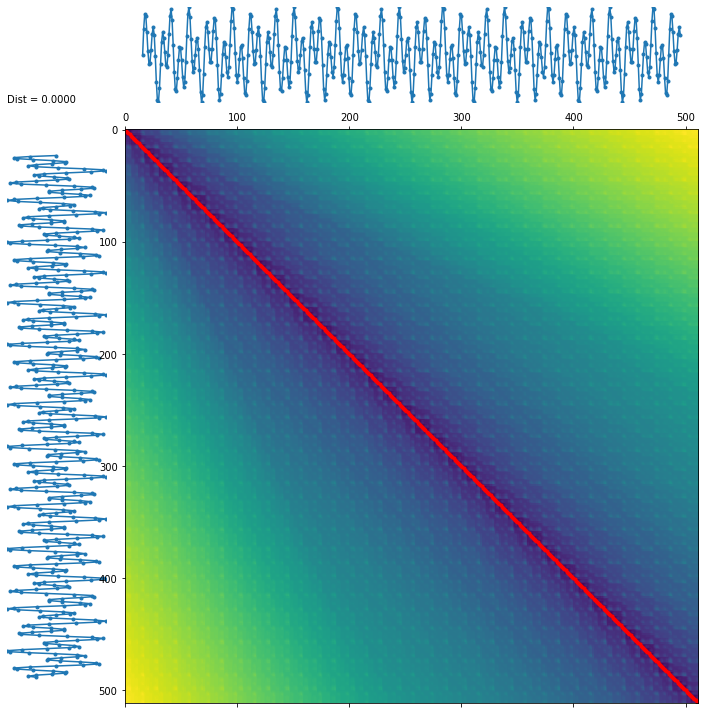

In [5]:
# "inputcomplx512.dat" which is the original waveform data from ADSP's example, length of data which is 1024, 
# and the data structure is Re[0], Im[0], Re[1], Im[1], Re[2], Im[2], Re[3], Im[3]... Re[511], Im[511].
# (the imaginary parts of data which is 0 now!!!!)
#
#
# in python or matlab's fft/ifft process, each element will be packed as a complex number,
# if it's in time domain signal like the case above, the element of a array will look like this 0.75+0j,
# 
# 
# with above's explaination, we can remove the 0 inside the "inputcomplx512.dat"
ct_data = read_data("fft_data/inputcomplx512.dat")[0::2] 

# get fft(x(n)), the result contains real part and complex part
fft_product = np.fft.fft(ct_data)

# get ifft(x(n)), the result contains real part and complex part
ifft_product = np.fft.ifft(fft_product)

# create x axis for 4 plot
x_axis = np.arange(len(ct_data))

# create 2*2 plots
fig, axes = plt.subplots(2, 3, figsize=(13, 12))

# plot x(n)
axes[0][0].plot(x_axis, ct_data)
axes[0][0].set_title('Original Waveform\n Continous Time')
axes[0][0].grid()

# plot abs(fft(x(n)))
axes[0][1].plot(x_axis, abs(fft_product))
axes[0][1].set_title('FFT Product\n sqrt(Real^2 + Imag^2)')
axes[0][1].grid()

# plot atan2(fft(x(n)).Imag, fft(x(n)).Real)
axes[0][2].plot(x_axis, np.arctan2(fft_product.imag, fft_product.real)*180/np.pi)
axes[0][2].set_title('FFT Product\n atan2(fft(x(n)).Imag, fft(x(n)).Real)')
axes[0][2].grid()

# plot ifft(fft(x(n))).Real
axes[1][0].plot(x_axis, ifft_product.real)
axes[1][0].set_title('IFFT Product\n Real Part')
axes[1][0].grid()

# plot ifft(fft(x(n))).Imaginary
axes[1][1].plot(x_axis, ifft_product.imag)
axes[1][1].set_title('IFFT Product\n Imaginary Part')
axes[1][1].set_ylim(-1, 1)
axes[1][1].grid()

# plot abs(ifft(fft(x(n))))
axes[1][2].plot(x_axis, abs(ifft_product))
axes[1][2].set_title('IFFT Product\n sqrt(Real^2 + Imag^2)')
axes[1][2].grid()

# dtw algorithm
s1 = np.array(ct_data)
s2 = np.array(ifft_product.real)

distance, paths = dtw.warping_paths(s1, s2)
best_path = dtw.best_path(paths)
dtwvis.plot_warpingpaths(s1, s2, paths, best_path)

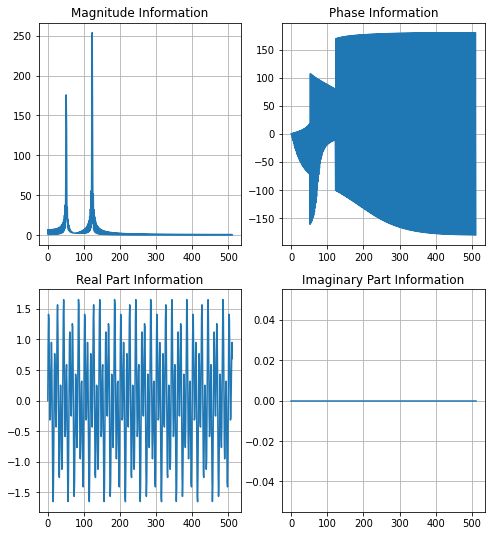

In [7]:
dataSet0 = read_data("fft_data/0412_fft_result.dat")
dataSet1 = read_data("fft_data/4012_ifft_result.dat")

x_axis = np.arange(len(dataSet0)//2)

y_axis_phase = np.zeros(len(dataSet0)//2)
y_axis_magnitude = np.zeros(len(dataSet0)//2)

Im_fft = np.zeros(len(dataSet0)//2)
Re_fft = np.zeros(len(dataSet0)//2)
Im_ifft = np.zeros(len(dataSet1)//2)
Re_ifft = np.zeros(len(dataSet1)//2)

for index, element in enumerate(dataSet0):
    if index % 2 == 1:
        Im_fft[(index-1)//2] = element
    else:
        Re_fft[(index)//2] = element

for index, element in enumerate(dataSet1):
    if index % 2 == 1:
        Im_ifft[(index-1)//2] = element
    else:
        Re_ifft[(index)//2] = element
        
for i in range(len(dataSet0)//2):
    y_axis_phase[i] = np.arctan2(Im_fft[i], Re_fft[i])*180/np.pi
    y_axis_magnitude[i] = np.sqrt(np.power(Im_fft[i],2)+np.power(Re_fft[i],2))
    
    
fig, axes = plt.subplots(2, 2, figsize=(8, 9))

axes[0][0].plot(x_axis, y_axis_magnitude)
axes[0][0].set_title('Magnitude Information')
axes[0][0].grid()

axes[0][1].plot(x_axis, y_axis_phase)
axes[0][1].set_title('Phase Information')
axes[0][1].grid()

axes[1][0].plot(x_axis, Re_ifft)
axes[1][0].set_title('Real Part Information')
axes[1][0].grid()

axes[1][1].plot(x_axis, Im_ifft)
axes[1][1].set_title('Imaginary Part Information')
axes[1][1].grid()